# Voronoi Plot

Jeg har fået inspiration til mine plots fra min bog Machine learning for algorithmic trading :D selv om jeg har droppet at læse bogen fra A-B, giver den mig sygt meget inspiration. Der står alt muligt lækkert i, og jeg tror det er det bogen er lavet til. ikke fra A-B, men et machine learning leksikon.

Voronoi plot giver en visuel fremvisning af hvordan modellen optimere sig selv.

In [11]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import numpy as np
import seaborn as sns
from matplotlib.colors import ListedColormap
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
from time import sleep
from numpy.random import uniform
from IPython import display

In [2]:
sns.set_style('white')
cmap = ListedColormap(sns.color_palette('Paired', 10))

In [3]:
data = pd.read_csv('data/heart_disease_cleaned.csv')

In [4]:
pca = PCA(n_components=2)
pca_data = pca.fit_transform(data)

pca_x = pca_data[:, 0]
pca_y = pca_data[:, 1]

In [5]:
kmeans_kwargs = {
"init": "k-means++",
"n_init": 15,
"random_state": 42,
}

In [6]:
n_clusters = 2

kmeans = KMeans(n_clusters, **kmeans_kwargs)

kmeans.fit(pca_data)

c:\Users\Christian\anaconda3\envs\ml-env\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


KMeans(n_clusters=2, n_init=15, random_state=42)

In [7]:
x_min, x_max = pca_x.min() - 1, pca_x.max() + 1
y_min, y_max = pca_y.min() - 1, pca_y.max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, .01), 
                     np.arange(y_min, y_max, .01))

In [8]:
def distance_to_center(centroids, data, assignments, cdist):
    distance = 0
    for c, centroid in enumerate(centroids):
        assigned_points = data[assignments == c, :]
        distance += np.sum(cdist(assigned_points, centroid.reshape(-1, 2)))
    return distance

def optimize_centroids(data, assignments):
    data_combined = np.column_stack((assignments.reshape(-1, 1), data))
    centroids = pd.DataFrame(data=data_combined).groupby(0).mean()
    return centroids.values

def assign_points(centroids, data, cdist):
    dist = cdist(data, centroids)        # all pairwise distances
    assignments = np.argmin(dist, axis=1)   # centroid with min distance
    return assignments

def plot_voronoi(x, y, labels, centroids, assignments,
                 distance, iteration, step, ax, delay=1):
    ax.clear()
    ax.scatter(x, y, c=labels, s=20, cmap=cmap)

    # plot cluster centers
    ax.scatter(*centroids.T,
               marker='o',
               c='w',
               s=200,
               edgecolor='k',
               zorder=9)

    for i, c in enumerate(centroids):
        ax.scatter(c[0], c[1],
                   marker=f'${i}$',
                   s=50,
                   edgecolor='k',
                   zorder=10)

    # plot links to centroid
    cx, cy = centroids.T
    for i, label in enumerate(assignments):
        ax.plot([x[i], cx[label]], 
                [y[i], cy[label]], 
                ls='--',
                color='k', 
                lw=0.5)

    Z = assign_points(centroids, 
                      np.c_[xx.ravel(),  
                            yy.ravel()],
                            cdist).reshape(xx.shape)
    
    plt.imshow(Z, interpolation='nearest', 
               extent=(xx.min(), xx.max(), yy.min(), yy.max()),
               cmap=cmap, 
               aspect='auto', 
               origin='lower', 
               alpha=.2)
    title = f'Iteration: {iteration} | {step} | Distance: {distance:,.1f}'
    ax.set_title(title)
    sns.despine()
    display.display(plt.gcf())
    display.clear_output(wait=True)
    sleep(delay)

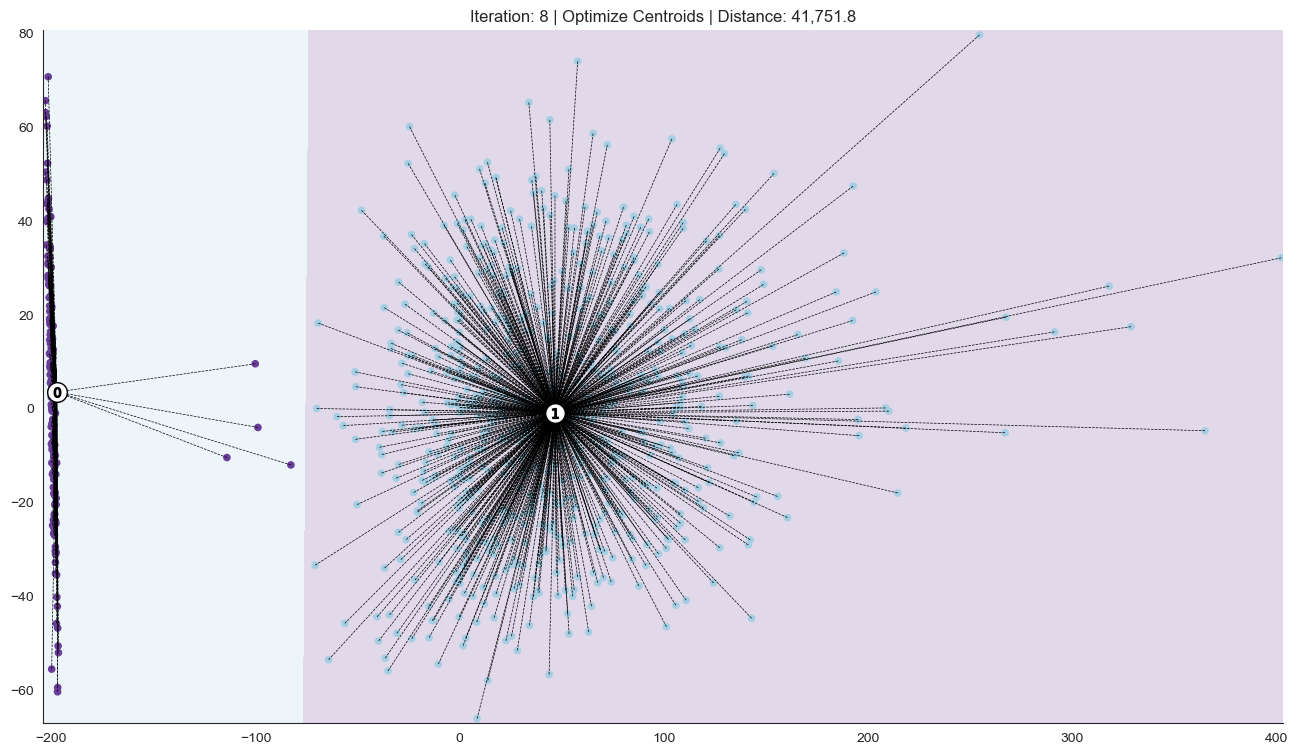

In [12]:
x_init = uniform(pca_x.min(), pca_x.max(),
                 size=n_clusters)
y_init = uniform(pca_y.min(), pca_y.max(),
                 size=n_clusters)
centroids = np.column_stack((x_init, y_init))

distance = np.sum(np.min(cdist(pca_data,
                               centroids),
                         axis=1))

fig, ax = plt.subplots(figsize=(16, 9))

iteration, tolerance, delta = 0, 1e-4, np.inf

while delta > tolerance:
    assignments = assign_points(centroids, pca_data, cdist)
    plot_voronoi(pca_x, pca_y, kmeans.labels_,
                 centroids,
                 assignments,
                 distance,
                 iteration,
                 step='Assign Data',
                 ax=ax)

    centroids = optimize_centroids(pca_data, assignments)
    delta = distance - distance_to_center(centroids,
                                          pca_data,
                                          assignments,
                                          cdist)
    distance -= delta

    plot_voronoi(pca_x, pca_y, kmeans.labels_,
                 centroids,
                 assignments,
                 distance,
                 iteration,
                 step='Optimize Centroids',
                 ax=ax)
    iteration += 1